# Using SimilaritySearch.jl to search Wiktionary (more than 1M english words under the Levenshtein distance)

This example shows how to create an index and solve queries using the Levenshtein distance using our `SearchGraph` index. Here we also show a UMAP visualization (click the button to compute it), with several parameters. Please feel free to probe everything, but be careful since Levenshtein distance could be quite expensive. 

Note: this notebook must be run with Jupyter and the environment variable JULIA_NUM_THREADS=auto, e.g., start the jupyter 


```bash
JULIA_NUM_THREADS=auto jupyter-lab .
```


Note 1: There is no too much information of Levenshtein distance visualizations in the literature, it would be interesting to mine the latent clusters.

Note 2: The projections take some time in my 32-cores system (approx. 5 min, plust the the indexing that takes aprox. 1 min with data loading, using 32 threads using 32 threads), so think about this before running this notebook.

In [1]:
using Pkg
Pkg.activate(".")
Pkg.add([
    PackageSpec(name="SimilaritySearch", version="0.9"),
    PackageSpec(name="SimSearchManifoldLearning", version="0.2"),
    PackageSpec(name="Plots"),
    PackageSpec(name="Strs", version="1.1"),
    PackageSpec(name="DataFrames", version="1.3.2"),
    PackageSpec(name="JLD2", version="0.4.22"),
    PackageSpec(name="HypertextLiteral"),
])

using SimilaritySearch, SimSearchManifoldLearning, Plots, LinearAlgebra, HypertextLiteral, Strs, DataFrames, JLD2
using Downloads: download


  Activating project at `~/Research/SimilaritySearchDemos/wiktionary`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Research/SimilaritySearchDemos/wiktionary/Project.toml`
  No Changes to `~/Research/SimilaritySearchDemos/wiktionary/Manifest.toml`


In [2]:
indexfile = "enwiktionary-index.jld2"
umapfile = "enwiktionary-umap-embeddings.jld2"
res = KnnResult(10)

url_ = "http://geo.ingeotec.mx/~sadit/similarity-search-demos"
dbfile = "enwiktionary.jld2"
!isfile(dbfile) && download("$url_/$dbfile", dbfile)

function create_index()
    db = VectorDatabase(load(dbfile, "enwiktionary").word)
    dist = LevenshteinDistance()
    G = SearchGraph(; db, dist, verbose=false)
    index!(G; parallel_block=512)
    optimize!(G, MinRecall(0.8))
    G
end


create_index (generic function with 1 method)

In [3]:
@time index = create_index()

 61.891321 seconds (87.79 M allocations: 3.858 GiB, 4.96% gc time, 16.10% compilation time)


SearchGraph{GenericLevenshteinDistance, VectorDatabase{Vector{UTF32Str}}, BeamSearch}
  dist: GenericLevenshteinDistance
  db: VectorDatabase{Vector{UTF32Str}}
  links: Array{Vector{Int32}}((1032895,))
  locks: Array{Base.Threads.SpinLock}((1032895,))
  hints: Array{Int32}((142,)) Int32[135, 465, 513, 517, 545, 610, 720, 733, 814, 1095  …  20945, 20967, 20969, 20988, 21007, 21039, 21048, 21058, 21062, 971072]
  search_algo: BeamSearch
  verbose: Bool false


In [4]:
function search_and_display(index, query, res, k=10)
	res = reuse!(res, k)
	@time search(index, query, res)
	L = []
	for (i, (id, d)) in enumerate(res)
		word = index[id]
		push!(L, @htl """
		<tr><td>$i</td><td>$(word)</td><td>$id</td><td>$(round(d, digits=3)) </td><td><a href="https://en.wiktionary.org/wiki/$(word)" target="_blank">meaning</a></td></tr>
		""")
	end
	
	@htl """

<h2>Query "$(query)", n=$(length(index))</h2>
<table>
<tr><td>knn</td><td>word</td><td>id</td><td>dist</td><td>wiktionary</td></tr>
$L
</table>

	"""
end


search_and_display (generic function with 2 methods)

# Random queries

In [5]:
n = length(index)

for i in 1:5
    q = index[rand(1:n)]
    search_and_display(index, q, res) |> display
end

  0.001311 seconds (2 allocations: 1.062 KiB)


knn,word,id,dist,wiktionary
1,B road,138545,0.0,meaning
2,Broad,750946,1.0,meaning
3,B roads,248478,1.0,meaning
4,A road,138544,1.0,meaning
5,Brad,38617,2.0,meaning
6,Broad.,515128,2.0,meaning
7,road,2954,2.0,meaning
8,A-road,46615,2.0,meaning
9,inroad,123663,2.0,meaning
10,abroad,390,2.0,meaning


  0.008667 seconds (4 allocations: 10.812 KiB)


knn,word,id,dist,wiktionary
1,sale price,65424,0.0,meaning
2,sale prices,704272,1.0,meaning
3,safe prime,551927,2.0,meaning
4,half-price,157513,3.0,meaning
5,safe place,984453,3.0,meaning
6,spot price,279069,3.0,meaning
7,take pride,302270,3.0,meaning
8,safe primes,551928,3.0,meaning
9,full price,997623,3.0,meaning
10,allspice,25053,4.0,meaning


  0.002150 seconds (4 allocations: 4.250 KiB)


knn,word,id,dist,wiktionary
1,duty-men,608098,0.0,meaning
2,duty men,608100,1.0,meaning
3,dutymen,608096,1.0,meaning
4,duty-man,608097,1.0,meaning
5,dutchmen,234003,2.0,meaning
6,duty man,608099,2.0,meaning
7,dutyman,608095,2.0,meaning
8,jurymen,169679,3.0,meaning
9,duramen,188646,3.0,meaning
10,dunnymen,535720,3.0,meaning


  0.003682 seconds (4 allocations: 4.250 KiB)


knn,word,id,dist,wiktionary
1,leg stumps,697540,0.0,meaning
2,leg stump,46427,1.0,meaning
3,restumps,464079,3.0,meaning
4,off stumps,700372,3.0,meaning
5,tree stumps,945665,3.0,meaning
6,leg slips,320234,3.0,meaning
7,legaturas,652171,4.0,meaning
8,leg curls,277429,4.0,meaning
9,leg up,1386,4.0,meaning
10,ligustrums,332362,4.0,meaning


  0.003334 seconds (4 allocations: 4.250 KiB)


knn,word,id,dist,wiktionary
1,beanstalk,114702,0.0,meaning
2,beanstalks,122128,1.0,meaning
3,leafstalk,70241,2.0,meaning
4,beastial,263097,3.0,meaning
5,beanmeal,257306,3.0,meaning
6,bean ball,44593,3.0,meaning
7,beanball,255900,3.0,meaning
8,beamwalk,873885,3.0,meaning
9,betalk,369753,3.0,meaning
10,destalk,839887,3.0,meaning


# Direct queries

In [6]:
search_and_display(index, UTF32Str("jam"), res) |> display
search_and_display(index, UTF32Str("bartman"), res) |> display
search_and_display(index, UTF32Str("mississippi"), res) |> display
search_and_display(index, UTF32Str(""), res) |> display

  0.001505 seconds (4 allocations: 4.250 KiB)


knn,word,id,dist,wiktionary
1,jam,9699,0.0,meaning
2,aam,96,1.0,meaning
3,bam,2600,1.0,meaning
4,lam,3164,1.0,meaning
5,pam,3173,1.0,meaning
6,jay,4257,1.0,meaning
7,yam,8629,1.0,meaning
8,kam,10391,1.0,meaning
9,Sam,29586,1.0,meaning
10,Cam,38649,1.0,meaning


  0.002070 seconds (4 allocations: 4.250 KiB)


knn,word,id,dist,wiktionary
1,batman,9180,1.0,meaning
2,barman,69636,1.0,meaning
3,Hartman,115634,1.0,meaning
4,Cartman,322388,1.0,meaning
5,Zartman,760613,1.0,meaning
6,cartman,379354,1.0,meaning
7,Gartman,747672,1.0,meaning
8,Bartman,754948,1.0,meaning
9,bagman,45826,2.0,meaning
10,badman,84922,2.0,meaning


  0.003833 seconds (6 allocations: 11.875 KiB)


knn,word,id,dist,wiktionary
1,Mississippi,24272,1.0,meaning
2,Mississippis,644592,2.0,meaning
3,Mississippian,35637,3.0,meaning
4,Mississippians,217773,4.0,meaning
5,missis,90565,5.0,meaning
6,missits,430994,5.0,meaning
7,missies,193737,5.0,meaning
8,missish,339275,5.0,meaning
9,missises,600073,5.0,meaning
10,missishness,401882,5.0,meaning


  0.001064 seconds (4 allocations: 4.250 KiB)


knn,word,id,dist,wiktionary
1,℅,14900,1.0,meaning
2,♨,169808,1.0,meaning
3,℀,247697,1.0,meaning
4,℻,247698,1.0,meaning
5,℁,291745,1.0,meaning
6,℞,304036,1.0,meaning
7,℟,330697,1.0,meaning
8,AC,2530,2.0,meaning
9,DC,2531,2.0,meaning
10,OA,2620,2.0,meaning


# Visualization

## Functions to create low dimensional projections

In [7]:
function create_umap_embeddings(index; k=10, n_epochs=100, neg_sample_rate=3, tol=1e-3, layout=RandomLayout())
    #layout = RandomLayout()
    # increase both `n_epochs` and `neg_sample_rate` to improve projection
    #layout = SpectralLayout() ## the results are much better with Spectral layout
    U2 = fit(UMAP, index; k, neg_sample_rate, layout, n_epochs, tol)  # spectral layout is too slow for the input-data
    U3 = fit(U2, 3; neg_sample_rate, n_epochs, tol)  # reuses U2
    (e2=U2.embedding, e3=U3.embedding)
end

function normcolors(V)
    min_, max_ = extrema(V)
    V .= (V .- min_) ./ (max_ - min_)
    V .= clamp.(V, 0, 1)
end

function plot_umap(e2, e3)
    normcolors(@view e3[1, :])
    normcolors(@view e3[2, :])
    normcolors(@view e3[3, :])

    C = [RGB(c...) for c in eachcol(e3)]
    X = @view e2[1, :]
    Y = @view e2[2, :]
    P = scatter(X, Y, c=C, fmt=:png, size=(600, 600), ma=0.3, a=0.3, ms=2, msw=0, label="", yticks=nothing, xticks=nothing, xaxis=false, yaxis=false)
    display(plot!(title="colors are related to spatial proximity in the 3d projection")) 
end

plot_umap (generic function with 1 method)

UMAP projection can take a while, even on multithreading systems. More even because this example uses SpectralLayout since the number of elements allow it. Note that we are creating 2d and 3d projections

In [8]:
@time e2, e3 = create_umap_embeddings(index);

102.252508 seconds (2.26 M allocations: 3.873 GiB, 0.60% gc time)
264.590871 seconds (24.17 M allocations: 5.976 GiB, 1.19% gc time, 3.73% compilation time)


*** computing graph
*** layout embedding RandomLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 5.880888526
- embedding init: 0.010261478
- embedding opt: 77.666923795



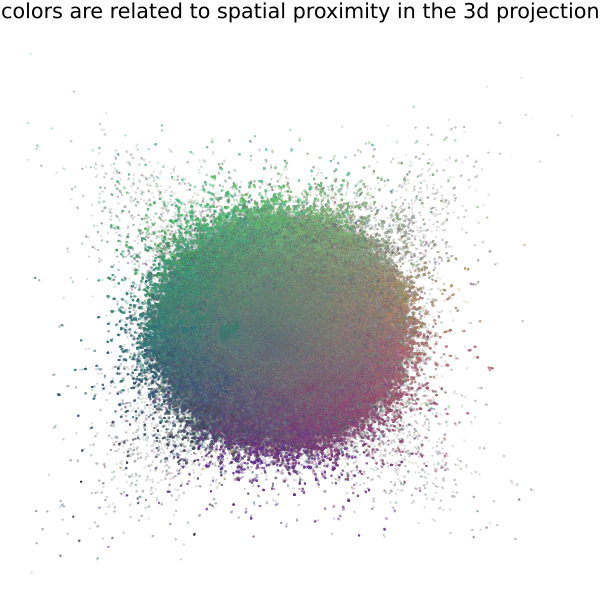

In [9]:
plot_umap(e2, e3)

# Final notes

This example shows how to index, query, and visualize the wiktionary dataset under the Levenshtein distance. The visualization is made with UMAP low-dimensional projections. 

Low dimensional projections are made with `SimSearchManifoldLearning`, note that `SimilaritySearch` is also used for computing the all $k$ nearest neighbors needed by the UMAP model. Note that this notebook should be ran with several threads to reduce time costs.

The precise packages used in this example are listed below

In [10]:
Pkg.status()

      Status `~/Research/SimilaritySearchDemos/wiktionary/Project.toml`
  [a93c6f00] DataFrames v1.3.2
  [ac1192a8] HypertextLiteral v0.9.4
  [033835bb] JLD2 v0.4.22
  [91a5bcdd] Plots v1.30.1
  [ca7ab67e] SimSearchManifoldLearning v0.2.4
  [053f045d] SimilaritySearch v0.9.2
  [7bddbee9] Strs v1.1.0
